### Challenge 06 - Store Sales: Time Series Forecasting


- Perform exploratory data analysis
- Build a solid baseline model
- Tune models using validation strategies
- Incorporate time-series features
- Make final predictions for submission

In [583]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [584]:
df = pd.read_csv('../data/store-sales-time-series-forecasting/train.csv')
df_holiday = pd.read_csv('../data/store-sales-time-series-forecasting/holidays_events.csv')

In [585]:
# df = df.drop_duplicates('date')
# df_holiday = df_holiday.drop_duplicates('date')

In [586]:
print(df.isnull().sum())
print(df_holiday.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


In [587]:
df['date'] = pd.to_datetime(df['date'])
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [588]:
print(df['date'].min(), df['date'].max())

2013-01-01 00:00:00 2017-08-15 00:00:00


In [589]:
df.info()
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)

In [590]:
df_holiday = df_holiday[['date', 'type', 'locale', 'description']]

In [591]:
df_holiday = df_holiday[df_holiday['type'] != 'Transfer']
df_holiday = df_holiday[df_holiday['locale'] != 'National']


### Daily sales

<Axes: title={'center': 'Total Sales Over Time'}, xlabel='date'>

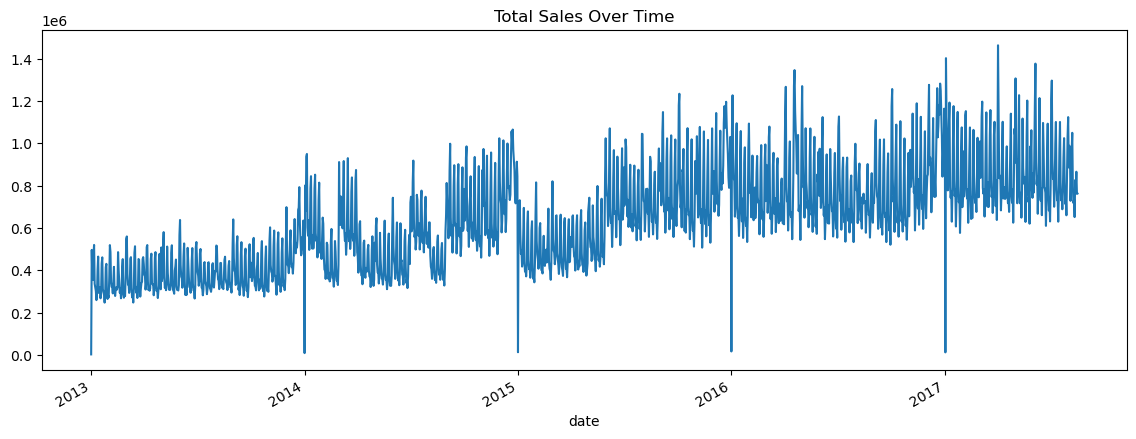

In [592]:
# Total sales over time
daily_sales = df.groupby('date')['sales'].sum()
daily_sales.plot(figsize=(14, 5), title='Total Sales Over Time')

Graph above shows:
- Sales increase year over year — this is a global growth signal.
- Those deep vertical drops almost to zero are likely holidays or closures.
- Sales get especially high in late-year periods — likely holiday season.

<Axes: title={'center': 'Average Sales by Day of Year'}, xlabel='day_month'>

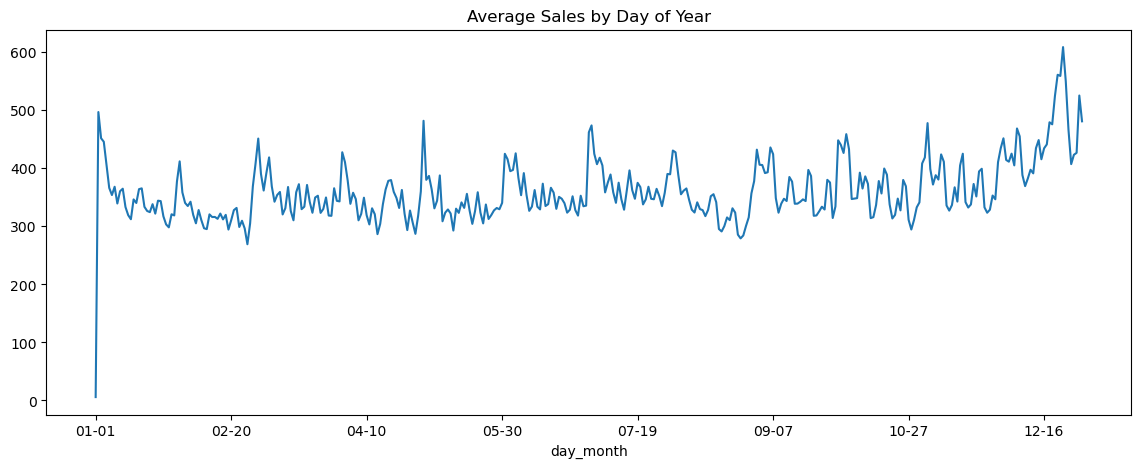

In [593]:
df['day_month'] = df['date'].dt.strftime('%m-%d')
pivot = df.groupby(['day_month'])['sales'].mean()
pivot.plot(figsize=(14,5), title='Average Sales by Day of Year')

Graph above shows:
- Jan 1 dip
    - Clearly visible and dramatic — probably zero sales that day.
    - Definitely include a is_new_year feature or even consider excluding that row when calculating moving averages.
- Rising trend in December
    - Strong upward slope starting mid-November — classic holiday sales ramp-up.
    - Suggests a feature like is_holiday_season = date >= Nov 15
- Spikes mid-year
    - These could correspond to local holidays or promotional events. To be investigated using the holidays_events.csv file.

<Axes: xlabel='date'>

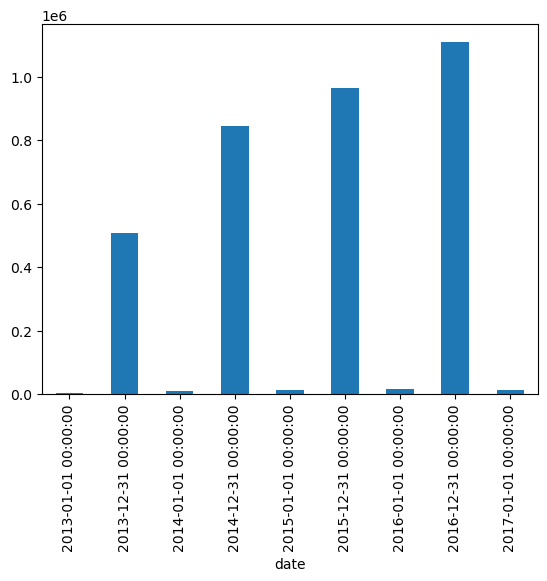

In [594]:
df[df['date'].dt.strftime('%m-%d').isin(['12-31', '01-01'])].groupby('date')['sales'].sum().plot(kind='bar')

Graph above shows:
- Spikes on Dec 31: Could be customers stocking up, end-of-year clearance, or final day of promos.
- Zero or near-zero on Jan 1: Store closures or minimal operations.

### Sales per store

<Axes: title={'center': 'Sales per Store Over Time'}, xlabel='date'>

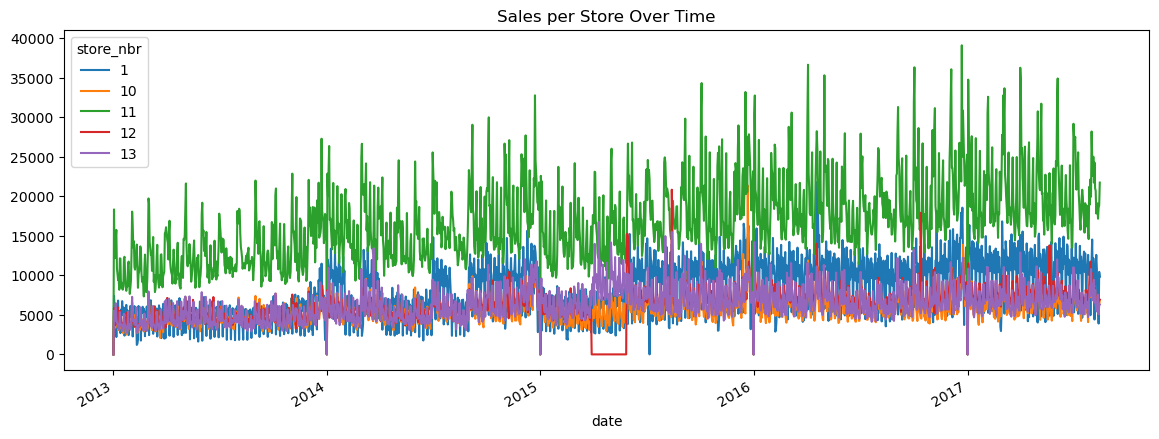

In [595]:
sample_stores = df['store_nbr'].unique()[:5]  # or use np.random.choice()
df_per_store = df.groupby(['date','store_nbr'])['sales'].sum().unstack()[sample_stores]
df_per_store.plot(figsize=(14, 5), title='Sales per Store Over Time')

Graph above shows:
- Store 11 has consistently higher sales → possibly a flagship or high-traffic location.
- Other stores follow similar patterns, just with lower magnitude. It means the sales shape is learnable, and the model can generalise across stores if store ID is included as a feature.

### Sales per family

<Axes: title={'center': 'Sales per Store Over Time'}, xlabel='date'>

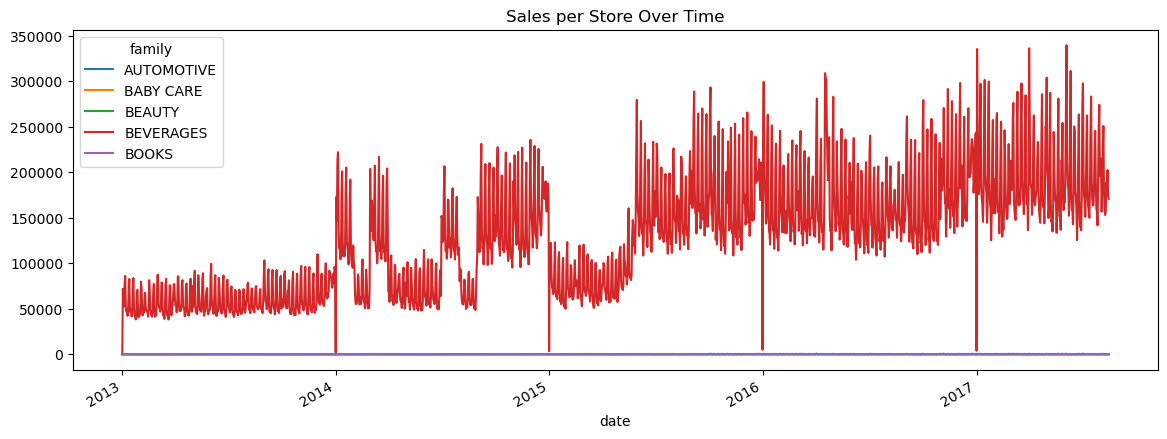

In [596]:
sample_stores = df['family'].unique()[:5]
df_per_store = df.groupby(['date','family'])['sales'].sum().unstack()[sample_stores]
df_per_store.plot(figsize=(14, 5), title='Sales per Store Over Time')

Graph above shows: 
- Beverages dominate sales volume by a large margin
- Other families (like Books, Automotive) have very low or flat sales, could be sparse or seasonal.

### Holiday events addition

In [597]:
df = df.merge(df_holiday, on='date', how='left')

In [598]:
print(len(df))

3027618


In [599]:
df['is_holiday'] = df['type'].notna()
df['holiday_type'] = df['type'].fillna('None')

In [600]:
df[df['is_holiday']].sort_values('date').head()

,id,date,store_nbr,family,sales,onpromotion,day_month,type,locale,description,is_holiday,holiday_type
106920,106920,2013-03-02,1,AUTOMOTIVE,1.0,0,03-02,Holiday,Local,Fundacion de Manta,True,Holiday
108114,108114,2013-03-02,42,CELEBRATION,0.0,0,03-02,Holiday,Local,Fundacion de Manta,True,Holiday
108113,108113,2013-03-02,42,BREAD/BAKERY,0.0,0,03-02,Holiday,Local,Fundacion de Manta,True,Holiday
108112,108112,2013-03-02,42,BOOKS,0.0,0,03-02,Holiday,Local,Fundacion de Manta,True,Holiday
108111,108111,2013-03-02,42,BEVERAGES,0.0,0,03-02,Holiday,Local,Fundacion de Manta,True,Holiday


### Lag feature engineering

In [601]:
df['sales_lag_1'] = df.groupby(['store_nbr', 'family'])['sales'].shift(1)
check = df[['store_nbr', 'family', 'date', 'sales', 'sales_lag_1']]
check[(check['store_nbr'] == 1) & (check['family'] == 'BEVERAGES')].head(10)

,store_nbr,family,date,sales,sales_lag_1
3,1,BEVERAGES,2013-01-01,0.0,NaN
1785,1,BEVERAGES,2013-01-02,1091.0,0.0
3567,1,BEVERAGES,2013-01-03,919.0,1091.0
5349,1,BEVERAGES,2013-01-04,953.0,919.0
7131,1,BEVERAGES,2013-01-05,1160.0,953.0
8913,1,BEVERAGES,2013-01-06,407.0,1160.0
10695,1,BEVERAGES,2013-01-07,1158.0,407.0
12477,1,BEVERAGES,2013-01-08,1029.0,1158.0
14259,1,BEVERAGES,2013-01-09,1186.0,1029.0
16041,1,BEVERAGES,2013-01-10,847.0,1186.0


In [602]:
df['sales_lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7)
check = df[['store_nbr', 'family', 'date', 'sales', 'sales_lag_7']]
check[(check['store_nbr'] == 1) & (check['family'] == 'BEVERAGES')].head(10)

,store_nbr,family,date,sales,sales_lag_7
3,1,BEVERAGES,2013-01-01,0.0,NaN
1785,1,BEVERAGES,2013-01-02,1091.0,NaN
3567,1,BEVERAGES,2013-01-03,919.0,NaN
5349,1,BEVERAGES,2013-01-04,953.0,NaN
7131,1,BEVERAGES,2013-01-05,1160.0,NaN
8913,1,BEVERAGES,2013-01-06,407.0,NaN
10695,1,BEVERAGES,2013-01-07,1158.0,NaN
12477,1,BEVERAGES,2013-01-08,1029.0,0.0
14259,1,BEVERAGES,2013-01-09,1186.0,1091.0
16041,1,BEVERAGES,2013-01-10,847.0,919.0


In [603]:
df['sales_lag_14'] = df.groupby(['store_nbr', 'family'])['sales'].shift(14)
check = df[['store_nbr', 'family', 'date', 'sales', 'sales_lag_14']]
check[(check['store_nbr'] == 1) & (check['family'] == 'BEVERAGES')].head(10)

,store_nbr,family,date,sales,sales_lag_14
3,1,BEVERAGES,2013-01-01,0.0,NaN
1785,1,BEVERAGES,2013-01-02,1091.0,NaN
3567,1,BEVERAGES,2013-01-03,919.0,NaN
5349,1,BEVERAGES,2013-01-04,953.0,NaN
7131,1,BEVERAGES,2013-01-05,1160.0,NaN
8913,1,BEVERAGES,2013-01-06,407.0,NaN
10695,1,BEVERAGES,2013-01-07,1158.0,NaN
12477,1,BEVERAGES,2013-01-08,1029.0,NaN
14259,1,BEVERAGES,2013-01-09,1186.0,NaN
16041,1,BEVERAGES,2013-01-10,847.0,NaN
